In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN, AgglomerativeClustering

c:\Users\khans\miniconda3\envs\managedata\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/book.tsv', sep='\t', header=None)
df = df.dropna(subset=[df.columns[3]])
df = df.reset_index(drop=True)

authors = df.iloc[:, 3]

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Uncomment this line to recreate embeddings
# author_embeddings = [model.encode(author) for author in authors]

# Comment this line if creating embeddings for the first time
author_embeddings = np.load('embeddings/author_embeddings.npy')

In [3]:
np.save('embeddings/author_embeddings.npy', author_embeddings)

In [4]:
cosine_similarities = cosine_similarity(author_embeddings)
print(cosine_similarities.shape)

(33246, 33246)


In [5]:
# Brute force approach: Group together all indices where cosine similarity is > 0.8
# undirected_graph = {} 
# for i in range(len(cosine_similarities)):
#     undirected_graph[i] = []

# for i in range(len(cosine_similarities)):
#     for j in range(i+1, len(cosine_similarities[0])):
#         if cosine_similarities[i][j] > 0.8:
#             undirected_graph[i].append(j)
#             undirected_graph[j].append(i)

# Create a graph where nodes are indices of the authors, and edges
# are added if the author embeddigns have a cosine similarity score
# above 0.8. Create both an undirected graph and a directed graph
row_indices, col_indices = np.where(cosine_similarities > 0.8)

groups = {}
undirected_graph = {} 

# Iterate over unique row indices
for i in np.unique(row_indices):
    # Find the column indices where cosine_similarities > 0.8 for this row
    relevant_cols = col_indices[row_indices == i]

    if i not in undirected_graph:
        undirected_graph[i] = []
    undirected_graph[i].extend(relevant_cols.tolist())

    for col in relevant_cols:
        if col not in undirected_graph:
            undirected_graph[col] = []
        undirected_graph[col].append(i)
    
    # Store relevant column indices in groups
    groups[i] = relevant_cols.tolist()

# Convert the lists to sets to remove duplicates in the undirected graph
for key in undirected_graph:
    undirected_graph[key] = list(set(undirected_graph[key]))

for i in range(len(df)):
    if i not in groups:
        groups[i] = []
    if i not in undirected_graph:
        undirected_graph[i] = [i]

In [6]:
# Find the components of the graph. Our transformer approach says that all entities
# in a component are the same entity
graph = groups.copy()
clusters = []
visited = set()

def dfs(v, curr_cluster):
    visited.add(v)
    curr_cluster.append(v)
    for w in graph[v]:
        if w not in visited:
            dfs(w, curr_cluster)

for node in graph:
    if node not in visited:
        cluster = []
        dfs(node, cluster)
        clusters.append(cluster)

# print(clusters)

In [7]:
# Output the components to a text file. This way we can look at what authors
# are grouped together at a glance
with open('../outputs/clusters.txt', 'w') as f:
    for clus in clusters:
        f.write('[')
        for idx in clus:
            f.write(f'{authors.iloc[idx]}; ')
        f.write(']\n\n')

In [8]:
print(len(clusters))
unique_values_count = df.iloc[:, 0].nunique()
print("Number of unique values in 'isbn' column:", unique_values_count)

1877
Number of unique values in 'isbn' column: 876


## This is the testing phase for the "authors" list. First, we find precision, recall, and MCC score exactly how the paper describes. Then, we do some exploratory work that was not done in the paper, which involves looking at how many unique strings there are per ISBN after entity resolution/consolidation. 

In [ ]:
########## Find precision and recall: start by identifying true positives and negatives ##########
np.random.seed(10)
same_second_col = []
diff_second_col = []

# Create a dictionary where keys are the unique values in the second column,
# and values are the corresponding rows
groups = {k: v for k, v in df.groupby(df.iloc[:, 1])}

for key, group in groups.items():
    # Get all possible pairs within each group
    pairs = list(zip(group.index, [key]*len(group), group.iloc[:, 3], group.index[1:], group.iloc[:, 3][1:]))
    same_second_col.extend(pairs)

# Shuffle the pairs to ensure randomness
np.random.shuffle(same_second_col)

# Get only the first 500 pairs
same_second_col = same_second_col[:500]

# For getting pairs with different second column values
while len(diff_second_col) < 500:
    # Randomly select two groups
    group1, group2 = np.random.choice(list(groups.keys()), 2, replace=False)
    if len(groups[group1]) > 0 and len(groups[group2]) > 0:
        # Randomly select one row from each group
        row1 = groups[group1].iloc[:, 3].sample(1)
        row2 = groups[group2].iloc[:, 3].sample(1)
        diff_second_col.append((row1.index[0], group1, row1.values[0], row2.index[0], group2, row2.values[0]))

# print("Pairs with same second column value: ", same_second_col)
# print("Pairs with different second column value: ", diff_second_col)

In [10]:
############# Find True/False Positives, True/False negatives #############
############# Then output precision, recall, and mcc as defined in the paper #############

# graph = groups.copy()
# clusters = []
# visited = set()

# see if there's a path from start to target
def can_reach(start, target, visited, graph):
    if visited is None:
        visited = set()
    visited.add(start)
    if start == target:
        return True
    for w in graph[start]:
        if w not in visited:
            if can_reach(w, target, visited, graph):
                return True
    return False

tp = fp = tn = fn = 0
for row_idx1, isbn, author1, row_idx2, author2 in same_second_col:
    if can_reach(row_idx1, row_idx2, set(), undirected_graph):
        tp += 1
    else:
        fn +=1 

for row_idx1, isbn1, author1, row_idx2, isbn2, author2 in diff_second_col:
    if can_reach(row_idx1, row_idx2, set(), undirected_graph):
        print(f'false positive: isbn1/author1: {isbn1}, {author1}\tisbn2/author2: {isbn2}, {author2}')
        fp += 1
    else:
        tn +=1

precision = tp/(tp + fp)
recall = tp/(tp + fn)
mcc = (tp*tn - fp*fn) / (np.sqrt(
    (tp + fp)*(tp+fn)*(tn+fp)*(tn+fn)
))

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'MCC: {mcc}')

Precision: 1.0
Recall: 0.848
MCC: 0.8579691784155833


In [11]:
# For now, set the golden entity to be the string with the longest length in the cluster
df_cleaned = df.copy(deep=True)

longest_authors = []

for cluster in clusters:
    cluster_strings = authors.iloc[cluster]
    longest_author = max(cluster_strings, key=len)
    longest_authors.append(longest_author)
    # print(f'{cluster_strings}\nLongest author: {longest_author}\n#######################\n')
    for clust_idx in cluster:
        df_cleaned.iloc[clust_idx, 3] = longest_author

# Output DataFrame to a TSV file
output_file = '../outputs/cleaned-book.tsv'
df_cleaned.to_csv(output_file, sep='\t', index=False)

In [12]:
#### For each ISBN, count the number of unique authors ####
result = df_cleaned.groupby(1)[3].nunique()
print(result)
result.to_csv('result.tsv', sep='\t', index=True)


1
0023606924       4
0080439977       5
0120121484       3
0120121506       3
0120121514       3
                ..
9780078204616    2
9780078216770    2
9780078227813    2
9780079136787    5
9780335216369    2
Name: 3, Length: 1263, dtype: int64


10


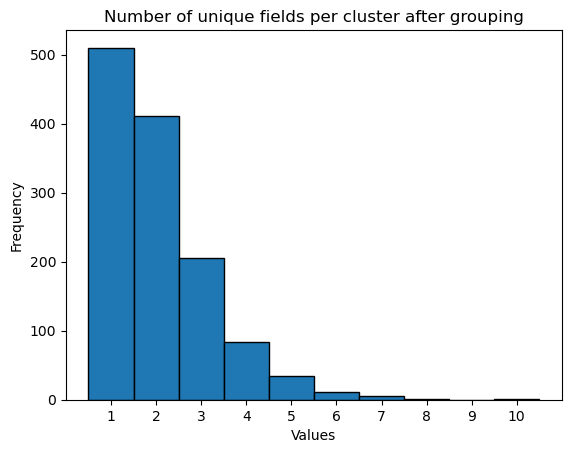

mean:  2.0427553444180524
median:  2.0
std:  1.1895248060401993
1st quartile:  1.0
3rd quartile:  3.0


In [13]:
# print(result.iloc[1])
print(result.max())
n_bins = result.max()
n, bins, patches = plt.hist(result, bins=n_bins, edgecolor='black') 
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Number of unique fields per cluster after grouping')
# Calculate centers of each bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# Set x-axis ticks to the calculated bin centers
plt.xticks(bin_centers, range(1, n_bins+1))
plt.show()

print('mean: ', result.mean())
print('median: ', result.median())
print('std: ', result.std())
print('1st quartile: ', result.quantile(0.25))
print('3rd quartile: ', result.quantile(0.75))

29


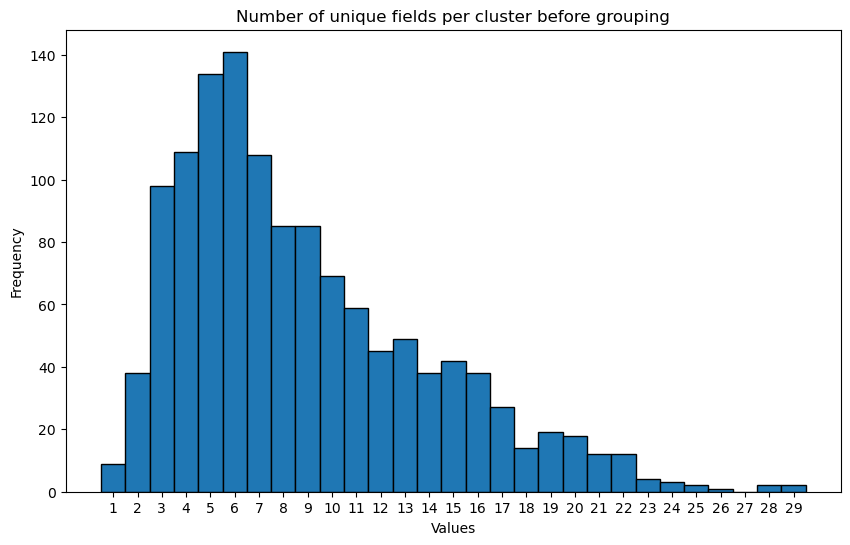

mean:  8.80443388756928
median:  7.0
std:  5.103422857019719
1st quartile:  5.0
3rd quartile:  12.0


In [14]:
old_df = df.groupby(1)[3].nunique()

print(old_df.max())
n_bins = old_df.max()
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(old_df, bins=n_bins,edgecolor='black') 
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Number of unique fields per cluster before grouping')
# Calculate centers of each bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# Set x-axis ticks to the calculated bin centers
plt.xticks(bin_centers, range(1, n_bins+1))
plt.show()

print('mean: ', old_df.mean())
print('median: ', old_df.median())
print('std: ', old_df.std())
print('1st quartile: ', old_df.quantile(0.25))
print('3rd quartile: ', old_df.quantile(0.75))

#### We can see that grouping the authors using the pre-trained transformer approach did help, but there are still some ISBNs with more than one unique author. The result.tsv file shows us the unique author counts for each ISBN number. We can look at the ISBNs with high unique author counts in the original dataset and find some problematic fields that are difficult for the pre-trained transformer model to resolve. Such author fields often leave out the authors first name, abbreviate several authors into et al., or have otherwise dirty data with excess words like "author", "editor", "by", etc. 

Authors filtered length: 30115
1
0023606924       3
0080439977       2
0120121484       2
0120121506       3
0120121514       2
                ..
9780078204616    2
9780078216770    1
9780078227813    2
9780079136787    2
9780335216369    2
Name: 3, Length: 1261, dtype: int64
6


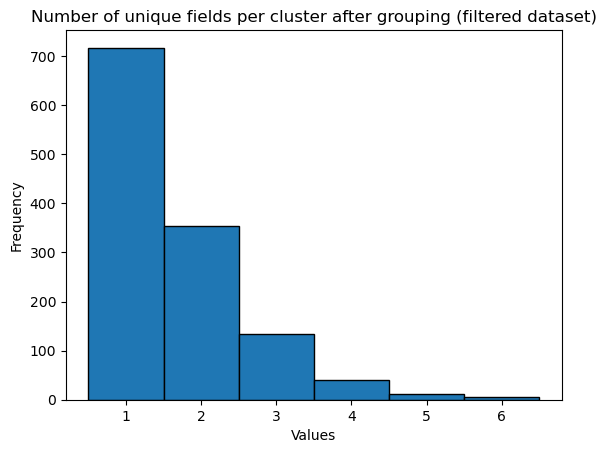

mean:  1.6447264076130055
median 1.0
std:  0.9062557851421786
1st quartile:  1.0
3rd quartile:  2.0


In [15]:
### Exploration: How well does this work in cases where there are
### no fields where the author is just one name, or several authors
### are abbreviated to et al?

def remove_substrings(cell):
    if isinstance(cell, str):
        return re.sub(r'\b(author|by|edited|editor)\b', '', cell, flags=re.IGNORECASE)
    else:
        return cell

#### Drop the relevant rows and recreate embeddings + cosine similarity matrix
df = df.reset_index(drop=True)
df_filtered = df[~((df.iloc[:, 3].str.split().str.len() == 1) | (df.iloc[:, 3].str.contains('et al|et. al')))]
df_filtered.iloc[:,3] = df_filtered.iloc[:,3].apply(remove_substrings)
authors = df_filtered.iloc[:, 3]

print(f'Authors filtered length: {len(authors)}')

# author_embeddings_filtered = [model.encode(author) for author in authors]
author_embeddings_filtered = np.load('embeddings/author_embeddings_filtered.npy')
np.save('embeddings/author_embeddings_filtered.npy', author_embeddings_filtered)

cosine_similarities_filtered = cosine_similarity(author_embeddings_filtered)

#### Cluster the similar authors
row_indices_f, col_indices_f = np.where(cosine_similarities_filtered > 0.8)
groups_f = {}
# Iterate over unique row indices
for i in np.unique(row_indices_f):
    # Find the column indices where cosine_similarities > 0.8 for this row
    relevant_cols_f = col_indices_f[row_indices_f == i]
    
    # Store relevant column indices in groups
    groups_f[i] = relevant_cols_f.tolist()

graph_f = groups_f.copy()
clusters_f = []
visited_f = set()

def dfs_f(v, curr_cluster):
    visited_f.add(v)
    curr_cluster.append(v)
    for w in graph_f[v]:
        if w not in visited_f:
            dfs_f(w, curr_cluster)

for node_f in graph_f:
    if node_f not in visited_f:
        cluster_f = []
        dfs_f(node_f, cluster_f)
        clusters_f.append(cluster_f)


#### Testing phase ####
df_cleaned_f = df_filtered.copy(deep=True)

longest_authors_f = []

for cluster_f in clusters_f:
    cluster_strings_f = authors.iloc[cluster_f]
    longest_author_f = max(cluster_strings_f, key=len)
    longest_authors_f.append(longest_author_f)
    # print(f'{cluster_strings}\nLongest author: {longest_author}\n#######################\n')
    for clust_idx in cluster_f:
        df_cleaned_f.iloc[clust_idx, 3] = longest_author_f

# Output DataFrame to a TSV file
output_file_f = '../outputs/cleaned-book-filtered.tsv'
df_cleaned_f.to_csv(output_file_f, sep='\t', index=False)

#### For each ISBN, count the number of unique authors ####
result_f = df_cleaned_f.groupby(1)[3].nunique()
print(result_f)
result_f.to_csv('../outputs/result-filtered.tsv', sep='\t', index=True)

print(result_f.max())
n_bins = result_f.max()
n, bins, patches = plt.hist(result_f, bins=n_bins, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Number of unique fields per cluster after grouping (filtered dataset)')
# Calculate centers of each bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# Set x-axis ticks to the calculated bin centers
plt.xticks(bin_centers, range(1, n_bins+1))
plt.show()

print('mean: ', result_f.mean())
print('median', result_f.median())
print('std: ', result_f.std())
print('1st quartile: ', result_f.quantile(0.25))
print('3rd quartile: ', result_f.quantile(0.75))

In [16]:
#######################################################################################
#################### Now let's do all this on the titles column!!! ####################
#######################################################################################
df = pd.read_csv('../data/book.tsv', sep='\t', header=None) # reread the data in case we messed with it
df = df.dropna(subset=[df.columns[2]])
titles = df.iloc[:, 2]

# title_embeddings = [model.encode(title) for title in titles]
title_embeddings = np.load('embeddings/title_embeddings.npy')
# np.save('embeddings/title_embeddings.npy', title_embeddings)

In [17]:
cosine_similarities_titles = cosine_similarity(title_embeddings)

# Construct the graph
row_indices, col_indices = np.where(cosine_similarities_titles > 0.8)
groups = {}
# Iterate over unique row indices
for i in np.unique(row_indices):
    # Find the column indices where cosine_similarities > 0.8 for this row
    relevant_cols = col_indices[row_indices == i]
    
    # Store relevant column indices in groups
    groups[i] = relevant_cols.tolist()

# Find the clusers 
graph = groups.copy()
clusters = []
visited = set()

def dfs(v, curr_cluster):
    visited.add(v)
    curr_cluster.append(v)
    for w in graph[v]:
        if w not in visited:
            dfs(w, curr_cluster)

for node in graph:
    if node not in visited:
        cluster = []
        dfs(node, cluster)
        clusters.append(cluster)

with open('../outputs/clusters-titles.txt', 'w') as f:
    for clus in clusters:
        f.write('[')
        for idx in clus:
            f.write(f'{titles.iloc[idx]}; ')
        f.write(']\n\n')

print('Number of clusters: ', len(clusters))
unique_values_count = df.iloc[:, 0].nunique()
print("Number of unique values in 'isbn' column:", unique_values_count)



Number of clusters:  1580
Number of unique values in 'isbn' column: 894


1
0023606924       2
0080439977       3
0120121484       3
0120121506       4
0120121514       2
                ..
9780078204616    3
9780078216770    2
9780078227813    3
9780079136787    3
9780335216369    1
Name: 2, Length: 1265, dtype: int64
6


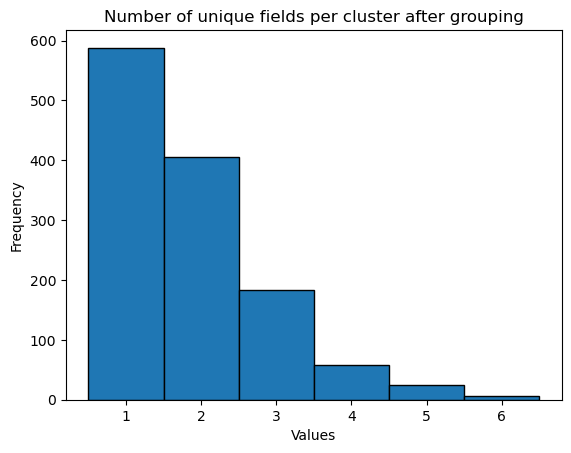

mean:  1.8474308300395257
median:  2.0
std:  1.0084901258897467
1st quartile:  1.0
3rd quartile:  2.0


In [18]:
#### Testing phase ####
# For now, set the golden entity to be the string with the longest length in the cluster
df_cleaned = df.copy(deep=True)

longest_titles = []

for cluster in clusters:
    cluster_strings = titles.iloc[cluster]
    longest_title = max(cluster_strings, key=len)
    longest_titles.append(longest_title)
    for clust_idx in cluster:
        df_cleaned.iloc[clust_idx, 2] = longest_title

# Output DataFrame to a TSV file
output_file = '../outputs/cleaned-book-titles.tsv'
df_cleaned.to_csv(output_file, sep='\t', index=False)

#### For each ISBN, count the number of unique titles ####
result = df_cleaned.groupby(1)[2].nunique()
print(result)
result.to_csv('../outputs/result-titles.tsv', sep='\t', index=True)

# print(result.iloc[1])
print(result.max())
n_bins = result.max()
n, bins, patches = plt.hist(result, bins=n_bins, edgecolor='black') 
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Number of unique fields per cluster after grouping')
# Calculate centers of each bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# Set x-axis ticks to the calculated bin centers
plt.xticks(bin_centers, range(1, n_bins+1))
plt.show()

print('mean: ', result.mean())
print('median: ', result.median())
print('std: ', result.std())
print('1st quartile: ', result.quantile(0.25))
print('3rd quartile: ', result.quantile(0.75))

30


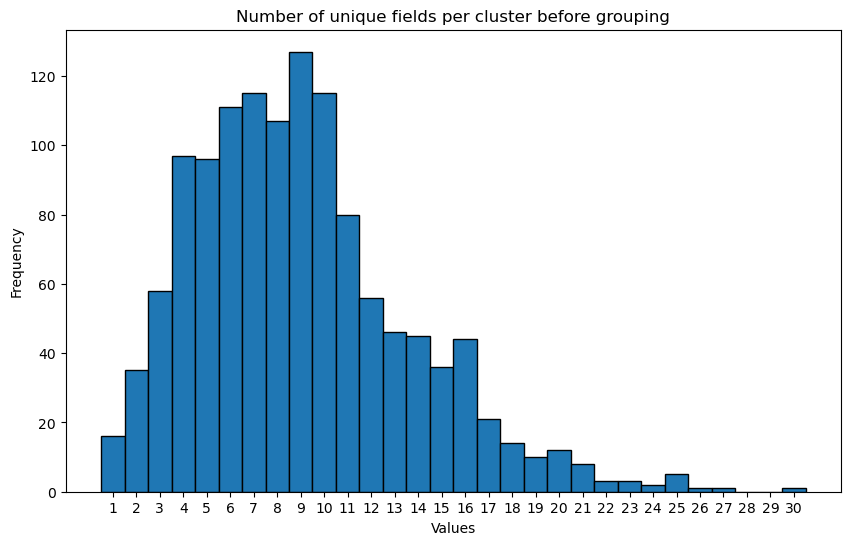

mean:  8.988142292490119
median:  8.0
std:  4.58454528672867
1st quartile:  6.0
3rd quartile:  11.0


In [19]:
old_df = df.groupby(1)[2].nunique()

print(old_df.max())
n_bins = old_df.max()
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(old_df, bins=n_bins,edgecolor='black') 
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Number of unique fields per cluster before grouping')
# Calculate centers of each bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# Set x-axis ticks to the calculated bin centers
plt.xticks(bin_centers, range(1, n_bins+1))
plt.show()

print('mean: ', old_df.mean())
print('median: ', old_df.median())
print('std: ', old_df.std())
print('1st quartile: ', old_df.quantile(0.25))
print('3rd quartile: ', old_df.quantile(0.75))